# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from tensorflow.keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):

        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  
  def __init__(self, name=None):
    super().__init__(name=name)
    
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(num_features, n_hidden_1)

    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)

    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)

  def __call__(self, x):

    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.out_layer(x2, activation=1)

    # Пам'ятай, що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax.
    # Робимо ми це для того, щоб
    # вихід нейронної мережі приймав значення від 0 до 1 відповідно до вірогідності
    # приналежності вхідного об'єкта до одного з 10 класів 

    return x3

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    
    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    
    corr_pred = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    return tf.reduce_mean(tf.cast(corr_pred, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.keras.optimizers.legacy.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Створимо список оптимізованих параметрів
    l2_reg=0.01
    l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in neural_net.trainable_variables])
    loss += l2_reg * l2_loss

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, neural_net.trainable_variables)
    
    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))  

In [7]:
loss_metric = tf.keras.metrics.Mean()
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = []  # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):

    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        
        loss_metric(loss)
        accuracy_metric(batch_y, pred)

        loss_history.append(loss_metric.result().numpy())
        accuracy_history.append(accuracy_metric.result().numpy())

        print(f"Step: {step}, loss: {loss_metric.result().numpy():.4f}, accuracy: {accuracy_metric.result().numpy():.4f}")


        loss_metric.reset_states()
        accuracy_metric.reset_states()


Step: 100, loss: 330.1407, accuracy: 0.6172
Step: 200, loss: 223.2159, accuracy: 0.7383
Step: 300, loss: 154.6422, accuracy: 0.8125
Step: 400, loss: 146.6552, accuracy: 0.8320
Step: 500, loss: 140.7815, accuracy: 0.8047
Step: 600, loss: 144.6827, accuracy: 0.8438
Step: 700, loss: 91.7743, accuracy: 0.8789
Step: 800, loss: 152.2180, accuracy: 0.8438
Step: 900, loss: 99.5526, accuracy: 0.8750
Step: 1000, loss: 100.3291, accuracy: 0.8828
Step: 1100, loss: 118.5532, accuracy: 0.8672
Step: 1200, loss: 75.6523, accuracy: 0.9414
Step: 1300, loss: 92.8835, accuracy: 0.8828
Step: 1400, loss: 99.7782, accuracy: 0.8750
Step: 1500, loss: 86.5865, accuracy: 0.9062
Step: 1600, loss: 85.9105, accuracy: 0.9219
Step: 1700, loss: 80.4335, accuracy: 0.8867
Step: 1800, loss: 56.4442, accuracy: 0.9258
Step: 1900, loss: 60.5932, accuracy: 0.9453
Step: 2000, loss: 73.5229, accuracy: 0.9141
Step: 2100, loss: 61.7741, accuracy: 0.9258
Step: 2200, loss: 95.4060, accuracy: 0.8906
Step: 2300, loss: 67.6267, accur

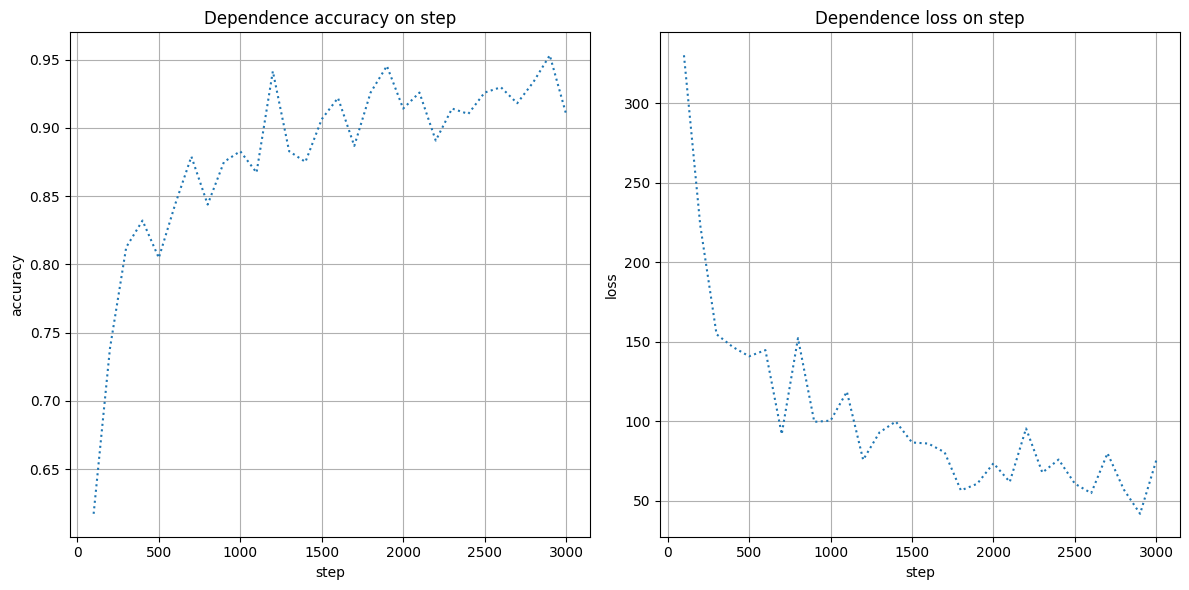

In [8]:
# Виведи графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

def show_plt(history, name, position):
    plt.subplot(1, 2, position)
    plt.plot(range(100, 3001, 100), history, linestyle=":")
    plt.title(f'Dependence {name} on step')
    plt.xlabel('step')
    plt.ylabel(f'{name}')
    plt.grid(True)

plt.figure(figsize=(12, 6))

# Перший графік - точність
plt.subplot(1, 2, 1)
show_plt(accuracy_history, "accuracy", 1)

# Другий графік - втрати
plt.subplot(1, 2, 2)
show_plt(loss_history, "loss", 2)

plt.tight_layout()
plt.show()

In [9]:
# Обчисли точність навченої нейромережі

result = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {result}")

Accuracy: 0.9227499961853027


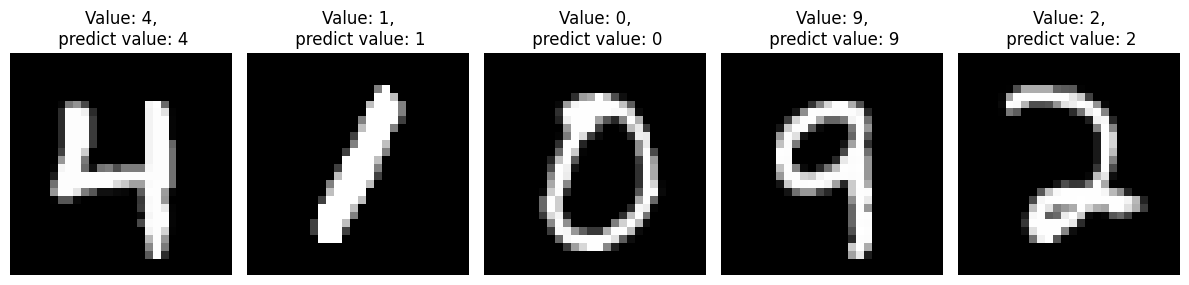

Accuracy of the trained neural network: 100.0%


In [10]:
# Протестуємо навчену нейромережу на 10 зображеннях. З тестової вибірки візьми 5
# випадкових зображень і передай їх у нейронну мережу.
# Виведи зображення та випиши поруч відповідь нейромережі.
# Зроби висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

images_number = 5
random_indices = random.sample(range(len(x_test)), images_number)
test_img = x_test[random_indices]
test_values = y_test[random_indices]

predict = neural_net(test_img)
predict_values = tf.argmax(predict, axis=1)

count_img = 0

fig, axes = plt.subplots(1, images_number, figsize=(12, 4))

for i in range(len(test_img)):
    image = test_img[i].reshape((28, 28))
    value = test_values[i]
    predict_value = predict_values[i]
    
    if predict_value == value:
        x = 100/images_number
        count_img += x
    
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Value: {value},\n predict value: {predict_value}")

plt.tight_layout()
plt.show()

print(f'Accuracy of the trained neural network: {count_img}%')


#### Висновок:
У рамках цього завдання ми успішно створили повнозв'язкову нейронну мережу за допомогою низькорівневих механізмів TensorFlow. Архітектура нашої мережі включає один вхідний шар, два прихованих шари і вихідний шар. Ці компоненти, спільно працюючи, дозволяють моделі витягувати та абстрагувати важливі ознаки з вхідних даних та робити точні передбачення.

Точність моделі на рівні ~92%. Це означає, що наша нейронна мережа змогла правильно класифікувати 92% вхідних прикладів. Цей результат свідчить, що модель навчилася отримувати важливі закономірності з даних, і здатна робити точні прогнози. Щоб досягти більш високої точності, можна збільшувати кількість шарів.